# Agregated metrics plot

Coco Yu

### Set Up Environment

Set up parameters as variables

In [ ]:
(study <- params$study)


[1] "ema"

[1] "1day"

[1] 0

[1] "v5"

[1] "nested"

[1] "main"

Function conflicts

In [ ]:
# source
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

Chunk Defaults

In [ ]:
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


Packages for script

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Source support functions

In [ ]:
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

Absolute paths

In [ ]:
path_fairema <- format_path(str_c("studydata/risk/data_processed/fairema"))


### Read in data

In [ ]:
df_sex <- read_csv(here::here(path_fairema, str_c("outer_preds_perf_", "sex", "_", window, 
                                           "_", lead, "_", version, "_", cv, "_", model,
                                           ".csv")),
                      col_types = cols())
df_sex$attribute <- "sex"

df_race <- read_csv(here::here(path_fairema, str_c("outer_preds_perf_", "race", "_", window, 
                                           "_", lead, "_", version, "_", cv, "_", model,
                                           ".csv")),
                    col_types = cols())
df_race$attribute <- "race"

df_income <- read_csv(here::here(path_fairema, str_c("outer_preds_perf_", "income", "_", window, 
                                           "_", lead, "_", version, "_", cv, "_", model,
                                           ".csv")),
                      col_types = cols())
df_income$attribute <- "income"

df_age <- read_csv(here::here(path_fairema, str_c("outer_preds_perf_", "age", "_", window, 
                                           "_", lead, "_", version, "_", cv, "_", model,
                                           ".csv")),
                   col_types = cols())
df_age$attribute <- "age"

df <- rbind(df_sex, df_race, df_income, df_age)


### Make Dataframes for plots

In [ ]:
mak_df_plot <- function(df){
  df |> 
    filter(group != "all", n_lapses != 0) |> 
    select(-n_lapses) |> 
    pivot_longer(-c("outer_split_num", "group", "attribute"),
               names_to = "metrics", values_to = "score") |>
    mutate(metrics = case_when(metrics == "balaccuracy" ~ "balanced accuracy",
                               metrics != "balaccuracy" ~ metrics),
           group = if_else(
             group %in% c("Female", "non_white", "below_poverty", "older"),
             "Unprivileged",
             "Privileged"
           )) |> 
    mutate(metrics = if_else(metrics == "prauc", "auPRC", metrics))
}


In [ ]:
df_sex <- mak_df_plot(df_sex)
df_race <- mak_df_plot(df_race)
df_income <- mak_df_plot(df_income)
df_age <- mak_df_plot(df_age)
df <- mak_df_plot(df)


### Construct Plots

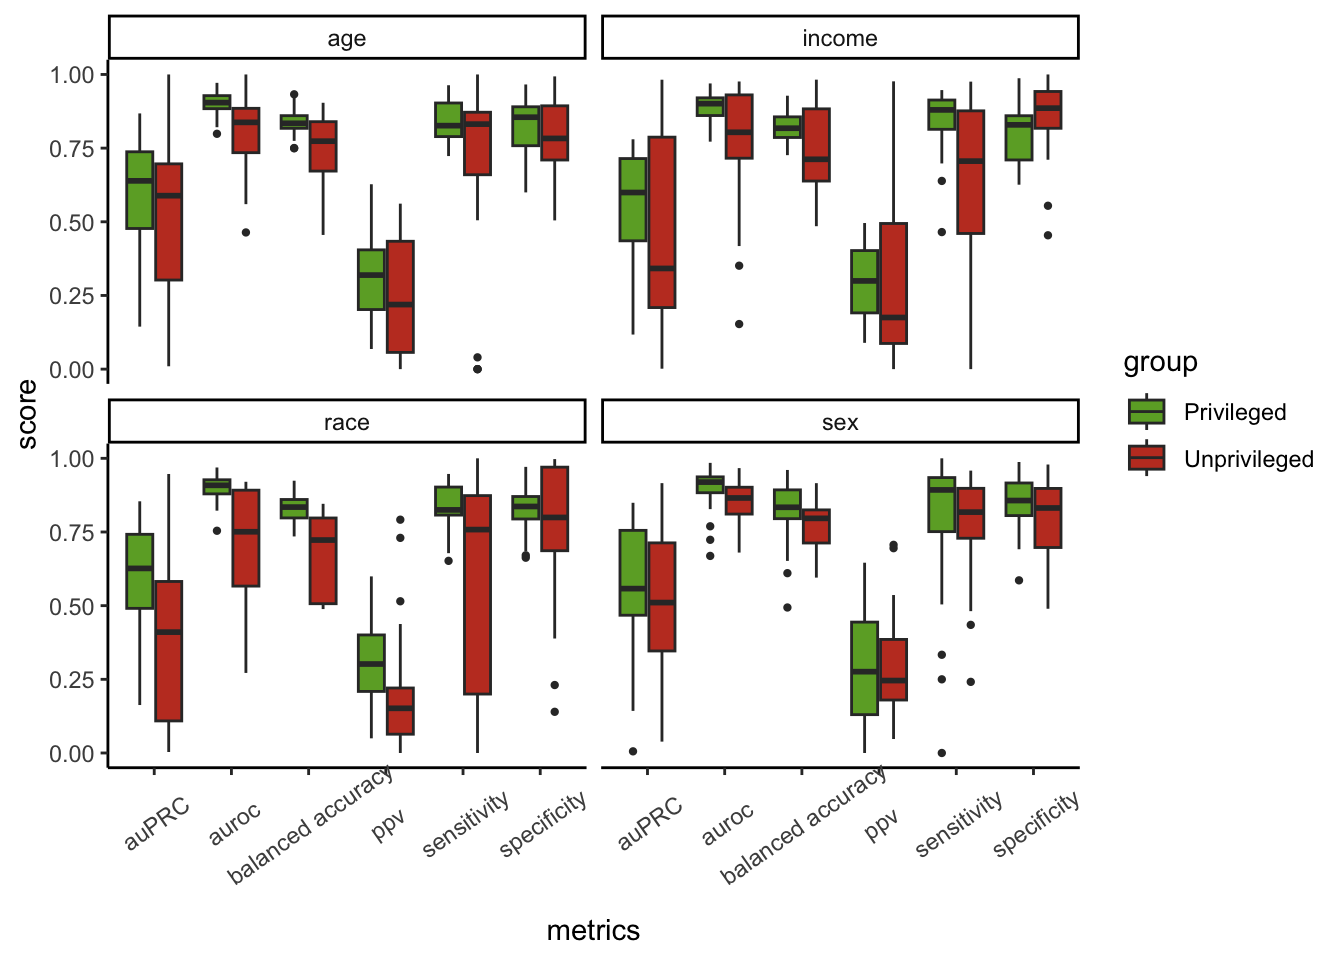

In [ ]:
df |> 
  ggplot(aes(x = metrics, y = score, fill = group)) +
  geom_boxplot(outlier.size = .8) +
  facet_wrap(~attribute) +
  scale_fill_manual(values = c("Privileged" = "#6CAA2F",
                               "Unprivileged" = "#C23E28")) +
  theme_classic() + 
  theme(axis.text.x=element_text(angle = 35, vjust = 0.7))


In [ ]:
output_plot <- function(df){
  ggarrange(
    df |> 
      filter(metrics %in% c("auroc", "auPRC")) |> 
      ggplot(aes(x = "", y = score, fill = group)) +
      geom_boxplot(outlier.size = .8) +
      facet_wrap(~metrics) +
      theme_void() +
      theme(axis.text.y = element_text(size = 8),
            strip.text = element_text(size = 12),
            plot.margin = margin(10, 50, 10, 50, "pt")) +
      scale_fill_manual(values = c("Privileged" = "#6CAA2F",
                                   "Unprivileged" = "#C23E28")) +
      labs(x = NULL),
    df |> 
      filter(metrics %in% c("sensitivity", "specificity", "ppv")) |> 
      ggplot(aes(x = "", y = score, fill = group)) +
      geom_boxplot(outlier.size = .8) +
      facet_wrap(~metrics) +
      theme_void() +
      theme(axis.text.y = element_text(size = 8),
            strip.text = element_text(size = 12),
            plot.margin = margin(10, 50, 10, 50, "pt")) +
      scale_fill_manual(values = c("Privileged" = "#6CAA2F",
                                   "Unprivileged" = "#C23E28")) +
      labs(x = NULL),
    nrow = 2,
    common.legend = TRUE,
    legend = "bottom",
    widths = c(2, 3)
  )
}


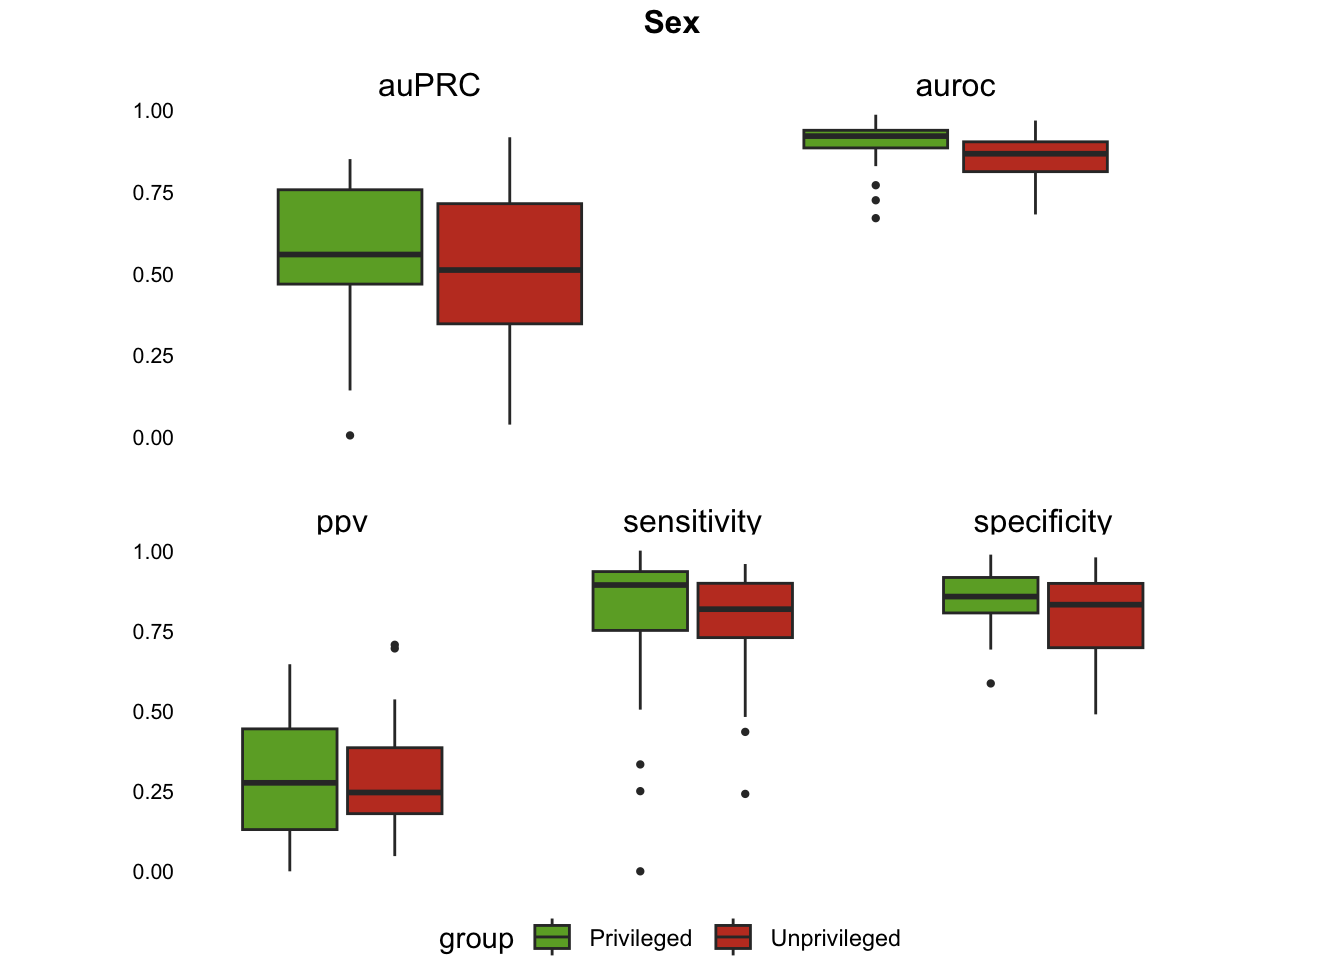

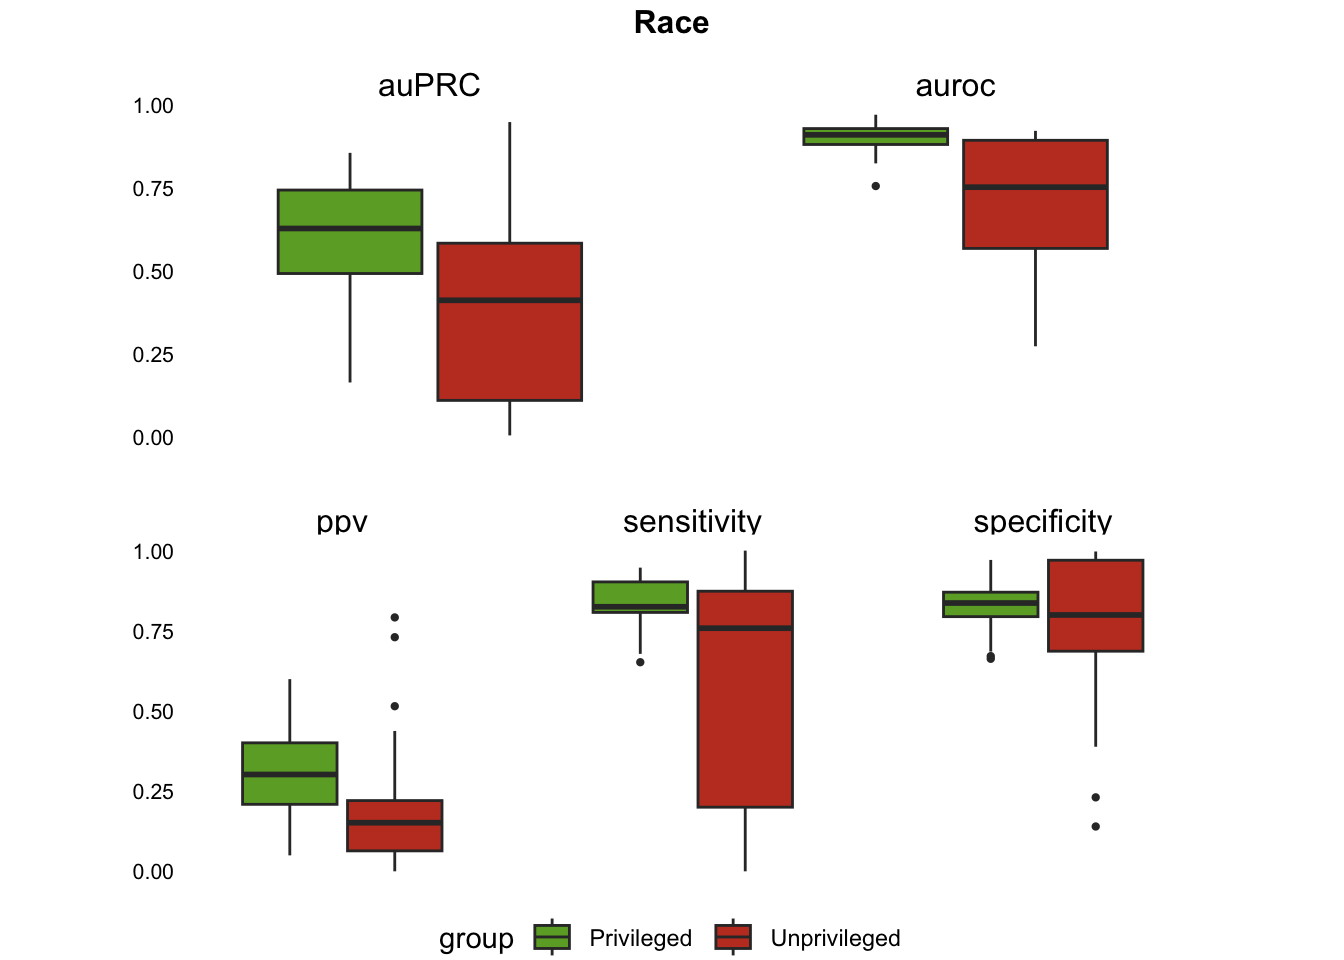

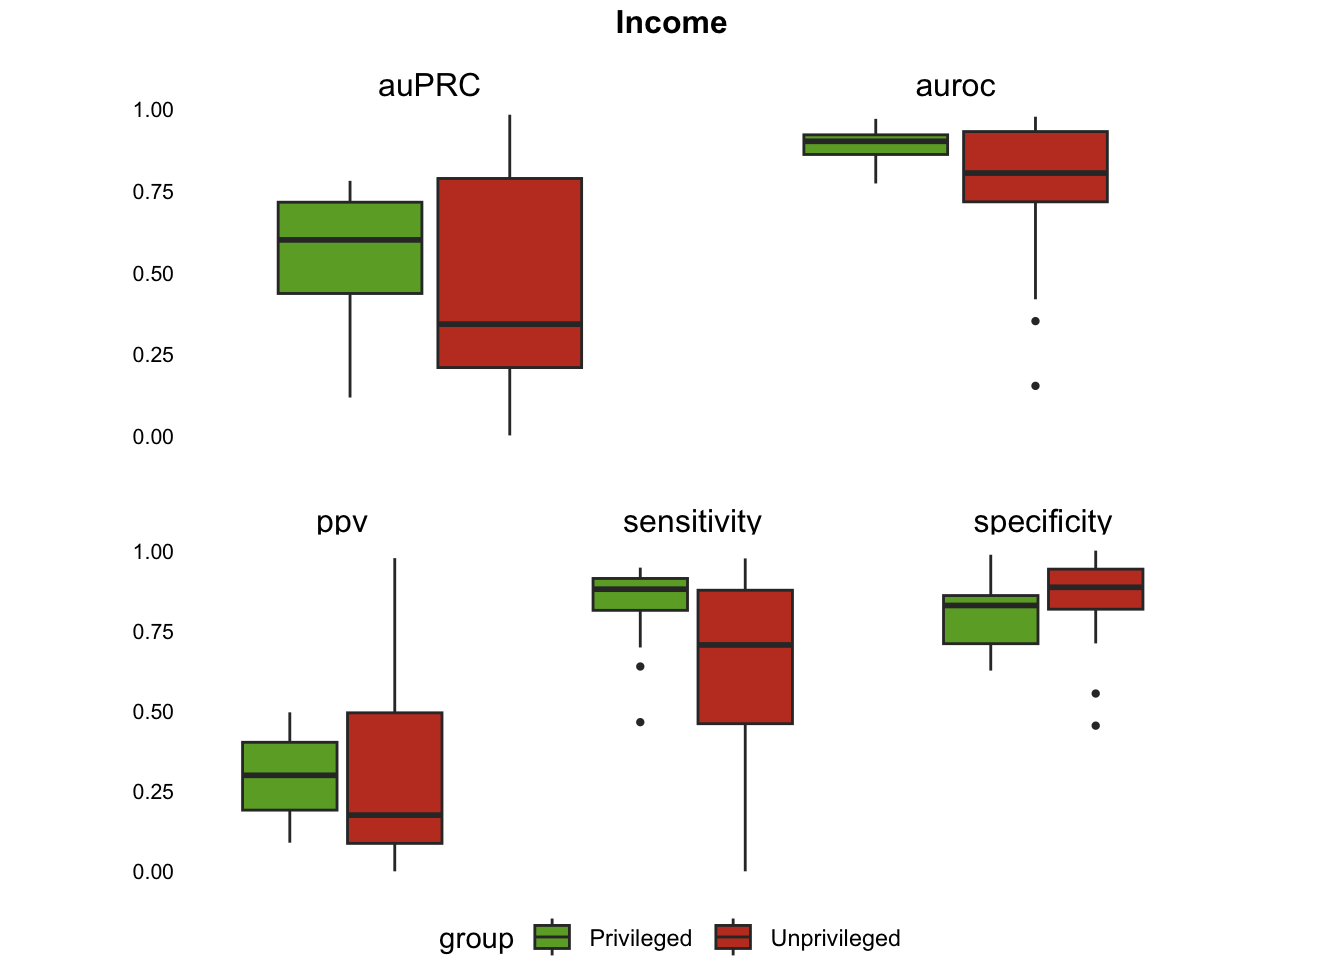

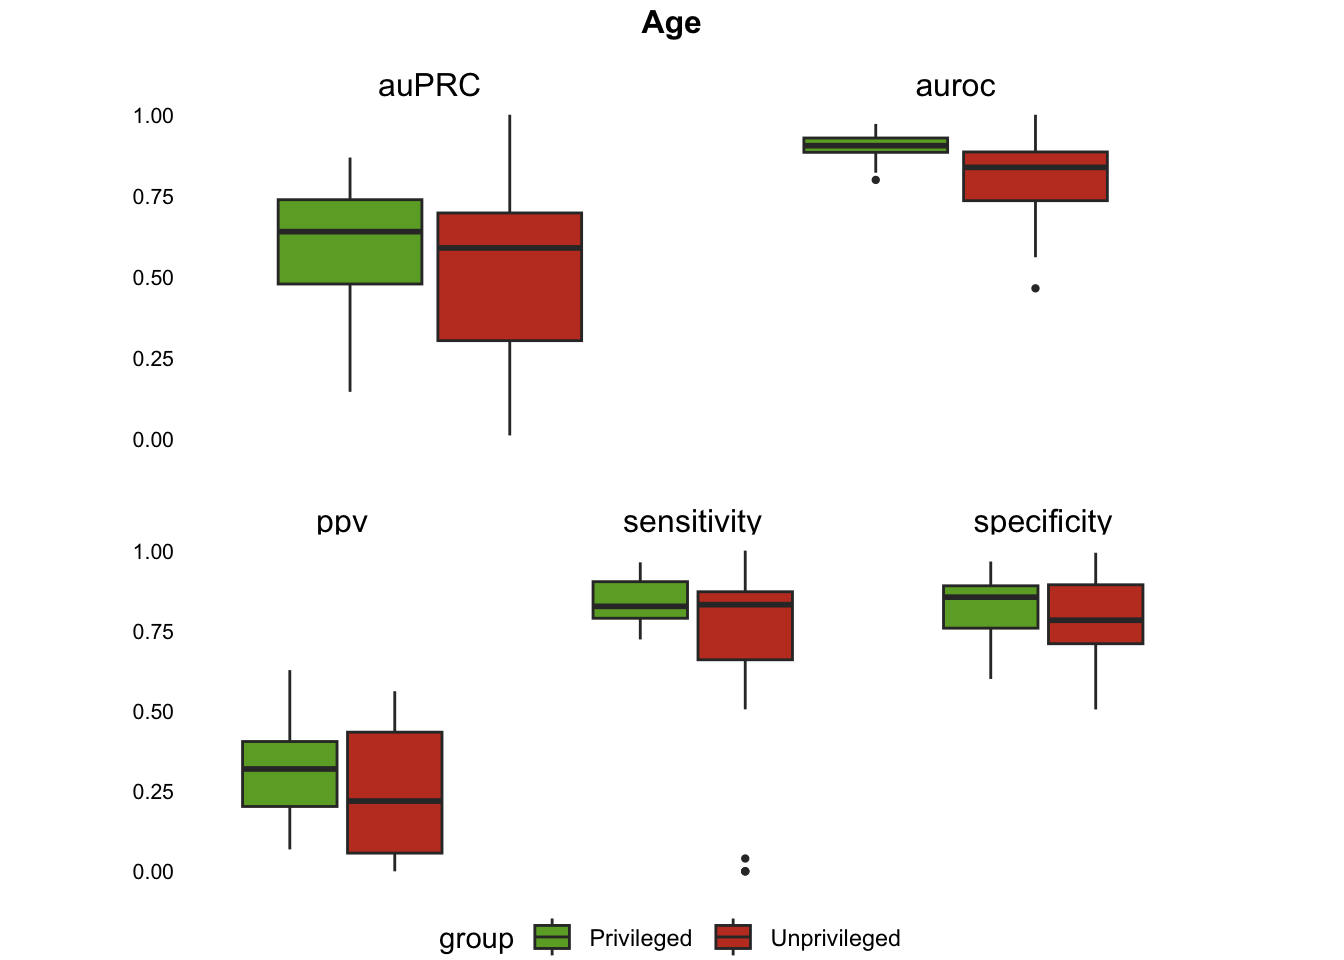

In [ ]:
output_plot(df_sex) |> 
  annotate_figure(top = text_grob("Sex", face = "bold"))


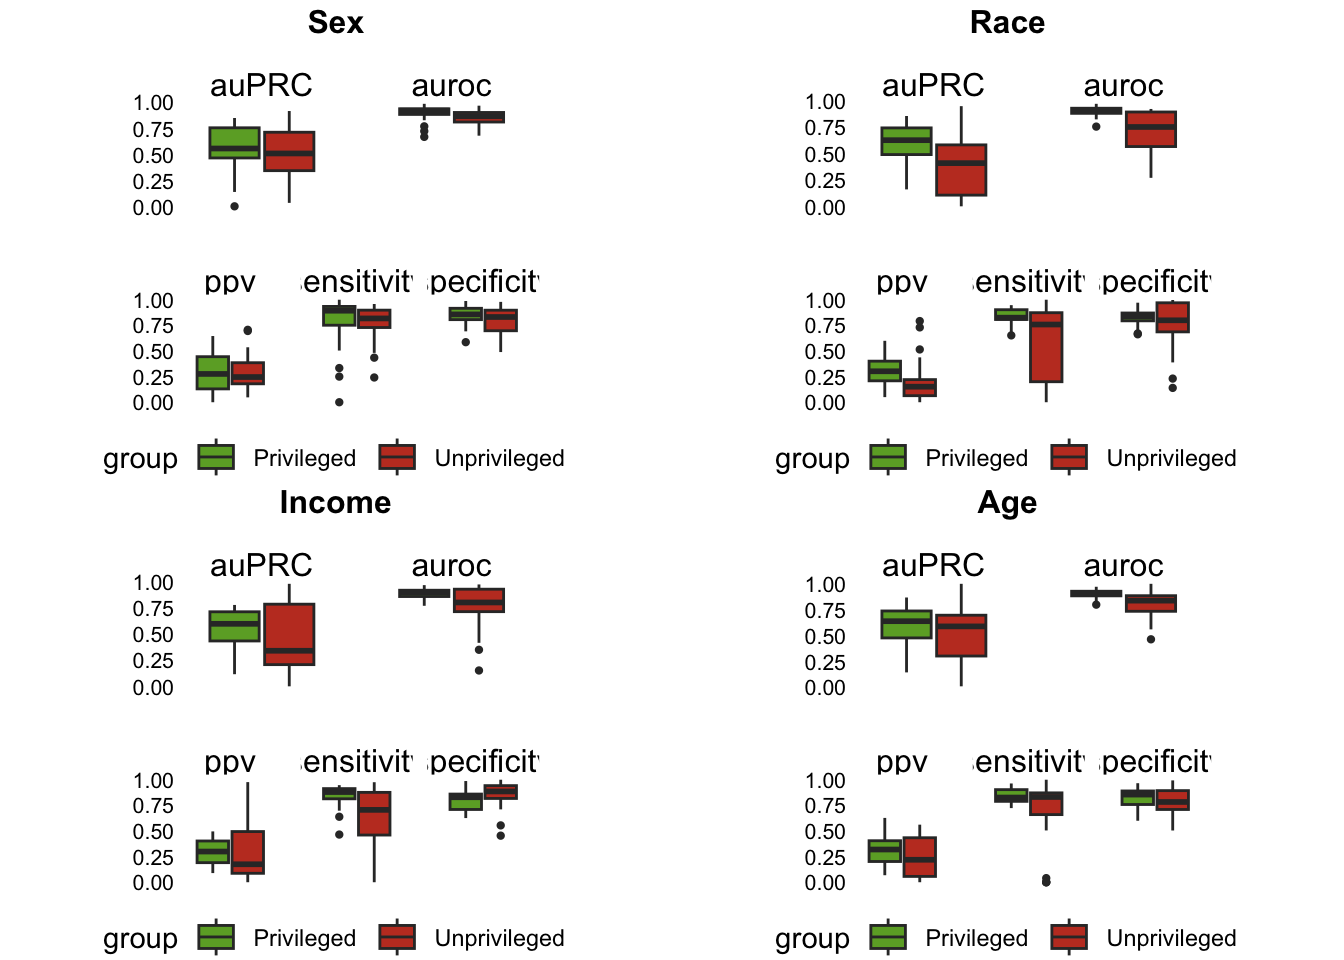

In [ ]:
ggarrange(
  annotate_figure(output_plot(df_sex), top = text_grob("Sex", face = "bold")),
  annotate_figure(output_plot(df_race), top = text_grob("Race", face = "bold")),
  annotate_figure(output_plot(df_income), top = text_grob("Income", face = "bold")),
  annotate_figure(output_plot(df_age), top = text_grob("Age", face = "bold"))
)
